# Wrangle and Analyze Data - WeRateDogs

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import zipfile
import tweepy
from tweepy import OAuthHandler
import json
import requests
import os
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import seaborn as sns
import warnings
import time

%matplotlib inline

## Gathering Data

We are going to gather data from 3 different places:

1. Twitter Archive - we read it from a saved csv file

In [2]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

2. Image Predictions - this is downloaded and parsed from an external URL

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [4]:
folder_name = 'image-predictions'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
with open(os.path.join(folder_name, url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)
os.listdir(folder_name)
image_predictions = pd.read_csv(folder_name + '/image-predictions.tsv', sep='\t')

3. Tweet specific info (likes, retweets) - this is pulled directly from Twitter's API, stored in a txt file locally and read into a Pandas dataframe

In [8]:
consumer_key = 'consumer_key'
consumer_secret = 'consumer_secret'
access_token = 'access_token'
access_secret = 'access_secret'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth_handler = auth, 
                 parser=tweepy.parsers.JSONParser(),
                 wait_on_rate_limit = True,
                 wait_on_rate_limit_notify = True)

In [8]:
tweet_id_list = np.array(twitter_archive['tweet_id'])
start_time = time.time()

with open('tweet_json.txt', 'w') as file:
    for tw in tweet_id_list:
        try:
            tweet = api.get_status(tw, tweet_mode='extended')
            file.write(json.dumps(tweet) + '\n')
        except tweepy.TweepError:
            invalid_id_list = np.array(tw)
            
end_time = time.time()
print("Whole process finished in {} seconds.".format(end_time - start_time))

Rate limit reached. Sleeping for: 757
Rate limit reached. Sleeping for: 764


Whole process finished in 1901.862833738327 seconds.


In [9]:
# Storing tweets info from json to a dataframe
tweets_list = pd.DataFrame(columns=['tweet_id', 'retweet_count', 'favorite_count'])
with open('tweet_json.txt', 'r') as file:
        for line in file:
            status = json.loads(line)
            tweet_id = status['id_str']
            retweet_count = status['retweet_count']
            favorite_count = status['favorite_count']
            tweets_list = tweets_list.append({'tweet_id': tweet_id,
                                              'retweet_count': retweet_count,
                                              'favorite_count': favorite_count}, ignore_index=True)

Now that we have read our 3 different files, let's look at the data they contain.

## Assessing Data

1. `twitter_archive` - let's look at the general structure, size and attributes in this dataframe

In [10]:
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


One thing we can quickly point out by looking at the columns in this table is the potential presence of records that correspond to retweets *retweeted_status_id* or replies *in_reply_to_user_id*. This is something we will assess in the next section, since we would like to focus on just the original Tweet data.

In [11]:
twitter_archive.duplicated().sum()

0

In [12]:
twitter_archive.tweet_id.duplicated().sum()

0

In [13]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

Some interesting numeric fields are rating numerator and denominator. Let's look at the range of possible values they take and their frequencies:

In [14]:
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [15]:
twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

It looks like there's some lack of standarization in the scale of assigned ratings. We'll look further into this in the cleaning section.

Now, let's take a look at the dog names: 

In [16]:
twitter_archive.name.value_counts()

None        745
a            55
Charlie      12
Oliver       11
Lucy         11
           ... 
Dug           1
Schnozz       1
Kallie        1
Vinscent      1
Bruno         1
Name: name, Length: 957, dtype: int64

At a first glance, we seem to have some issues with words that have been extracted from the Tweets that don't actually correspond with a real name (eg: *a*, repeated 55 times). We'll assess them in the next section.

Finally, let's also look into the variables *doggo*, *floofer*, *pupper*, *puppo*. They correspond to different stages of a dog, so let's find out how they're distributed: 

In [21]:
twitter_archive.groupby(['doggo', 'floofer', 'pupper','puppo']).size()

doggo  floofer  pupper  puppo
None   None     None    None     1976
                        puppo      29
                pupper  None      245
       floofer  None    None        9
doggo  None     None    None       83
                        puppo       1
                pupper  None       12
       floofer  None    None        1
dtype: int64

It looks like the possible combinations are very limited. Given that these four columns reference a common attribute, we'll combine them in the next section.

2. `image_predictions` - let's look at the general structure, size and attributes in this dataframe

In [22]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


One thing that we can quickly notice is the lack of standard guidelines naming dog breeds in columns *p1*, *p2* and *p3*. Let's have a quick summary of the most popular names in *p1*:

In [23]:
image_predictions.p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
EntleBucher             1
coho                    1
prayer_rug              1
sea_urchin              1
desktop_computer        1
Name: p1, Length: 378, dtype: int64

In [24]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [25]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


Because a *twee_id* can have up to 4 images (referenced in *img_num* column), we can explore what's the number of unique Tweets we have in the dataset:

In [26]:
image_predictions.tweet_id.nunique()

2075

So it looks like every tweet in the dataframe has only 1 entry, even though some values in 'img_num' go above 1. For example, this would be a Tweet with only 1 image labeled as *img_num* = 2:

In [28]:
image_predictions.loc[image_predictions.tweet_id == 891327558926688256]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.22577,True,German_short-haired_pointer,0.175219,True


3. `tweets_list` - let's look at the general structure, size and attributes in this dataframe

In [29]:
tweets_list

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7670,36030
1,892177421306343426,5671,31072
2,891815181378084864,3760,23386
3,891689557279858688,7835,39295
4,891327558926688256,8443,37512
...,...,...,...
2326,666049248165822465,40,96
2327,666044226329800704,131,271
2328,666033412701032449,41,112
2329,666029285002620928,42,121


One quick thing that stands out is the number of records (2331) not matching the number of *tweet_id*s in the `twitter_archive` dataframe (2356). We'll explore this.

In [30]:
tweets_list.describe()

,tweet_id,retweet_count,favorite_count
count,2331,2331,2331
unique,2331,1676,1994
top,889638837579907072,224,0
freq,1,6,163


In [31]:
tweets_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2331 non-null   object
 1   retweet_count   2331 non-null   object
 2   favorite_count  2331 non-null   object
dtypes: object(3)
memory usage: 54.8+ KB


This dataframe is simpler than the previous 2. It contains a couple of variables with the number of retweets and number of favorites counts for a given tweet. One thing to notice is that, even though these variables are clearly integers, the types are not defined as such. Also, for simplicity, we would like to merge this information with our `tweet_archive` table. We'll deal with this next.

### Assessing Data - Summary

#### Data Quality Issues
##### `twitter_archive` table
- Some rows are retweets and replies
- Missing values *in_reply_to_status_id*, *in_reply_to_user_id*, *retweeted_status_id*, *retweeted_status_user_id*, *retweeted_status_timestamp*, *expanded_urls*
- Extreme values for *numerator* and *denominator*
- Presence of wonky dog names

##### `image_predictions` table
- Nondescriptive column names: *p1*, *p1_conf*...
- Lack of standard guidelines naming dog breeds in columns *p1*, *p2* and *p3*

##### `tweets_list` table
- *tweet_id*, *retweet_count* and *favorite_count* are object type not integers
- Missing rows (25)

#### Tidiness Issues 
- Variable *stage* in 4 different columns
- `tweets_list` should be part of `twitter_archive` table 

## Cleaning Data

Let's start by creating a copy of our 3 datasets:

In [32]:
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
tweets_list_clean = tweets_list.copy()

Now we will assess, one by one, the issues described in the previous section:

#### `twitter_archive` table - Retweets and replies

##### Define
Remove retweets when columns *retweeted_status_id*, *retweeted_status_user_id* and *retweeted_status_timestamp* are non empty.  
Remove replies when columns *in_reply_to_status_id* and *in_reply_to_user_id* are non empty.  

##### Code

In [33]:
# Remove retweets
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.retweeted_status_id.isnull()]

# Remove replies
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.in_reply_to_status_id.isnull()]

##### Test

In [34]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2097 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2097 non-null   object 
 4   source                      2097 non-null   object 
 5   text                        2097 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2094 non-null   object 
 10  rating_numerator            2097 non-null   int64  
 11  rating_denominator          2097 non-null   int64  
 12  name                        2097 non-null   object 
 13  doggo                       2097 

##### Define
Drop columns *retweeted_status_id*, *retweeted_status_user_id*, *retweeted_status_timestamp*, *in_reply_to_status_id* and *in_reply_to_user_id*.  

##### Code

In [35]:
twitter_archive_clean.drop(columns=['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp',
                                    'in_reply_to_status_id', 'in_reply_to_user_id'], inplace=True)

##### Test

In [36]:
twitter_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### Missing values

##### Define
Fill in values for expanded urls. The format should be: "https://twitter.com/dog_rates/status/{tweet_id}/photo/1"   

##### Code

In [37]:
null_expanded_urls = twitter_archive_clean[twitter_archive_clean.expanded_urls.isnull()].tweet_id

In [38]:
for id_url_null in null_expanded_urls:
    twitter_archive_clean['expanded_urls'] = "https://twitter.com/dog_rates/status/{}/photo/1".format(id_url_null)

##### Test

In [39]:
twitter_archive_clean[twitter_archive_clean.expanded_urls.isnull()].tweet_id

Series([], Name: tweet_id, dtype: int64)

#### `twitter_archive` table - Extreme values for numerator and denominator

##### Define
Compute numerator/denominator and add this to a new *rating* column. Because *WeRateDogs* rating method tends to give high ratings, we'll keep a ratio up to 2 to 1. The ones that have ratio higher than 2 they'll be designated with a rating of 2. 
Drop the columns *rating_numerator* and *rating_denominator*.

##### Code

In [40]:
twitter_archive_clean['rating'] = twitter_archive_clean['rating_numerator']/twitter_archive_clean['rating_denominator']

In [41]:
twitter_archive_clean['rating'].describe()

count    2097.000000
mean        1.169281
std         3.965932
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max       177.600000
Name: rating, dtype: float64

In [42]:
twitter_archive_clean.loc[twitter_archive_clean['rating'] > 2, 'rating'] = 2

In [43]:
twitter_archive_clean.drop(columns=['rating_numerator', 'rating_denominator'], inplace=True)

##### Test

In [44]:
twitter_archive_clean['rating'].describe()

count    2097.000000
mean        1.062544
std         0.221584
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max         2.000000
Name: rating, dtype: float64

In [45]:
twitter_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,name,doggo,floofer,pupper,puppo,rating
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/696518437...,Phineas,None,None,None,None,1.3
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/696518437...,Tilly,None,None,None,None,1.3
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/696518437...,Archie,None,None,None,None,1.2
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/696518437...,Darla,None,None,None,None,1.3
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/696518437...,Franklin,None,None,None,None,1.2


#### `twitter_archive` table - Presence of wonky dog names

##### Define
Transform all the names that start with a lowercase to *None*.  

##### Code

In [46]:
strange_name = twitter_archive_clean.name.str.islower()
column_name = 'name'
twitter_archive_clean.loc[strange_name, column_name] = "None"

##### Test

In [47]:
twitter_archive_clean.name.value_counts()

None        707
Lucy         11
Charlie      11
Oliver       10
Cooper       10
           ... 
Heinrich      1
Clarq         1
Peanut        1
Eleanor       1
Balto         1
Name: name, Length: 930, dtype: int64

#### `image_predictions` table - Nondescriptive columns

##### Define
Change `image_predictions` column headers to more insightful ones.  

##### Code

In [48]:
image_predictions_clean = image_predictions_clean.rename(columns={'p1': 'prediction_1', 'p1_conf': 'confidence_1',
                                                                  'p1_dog': 'dog_1', 'p2': 'prediction_2',
                                                                  'p2_conf': 'confidence_2', 'p2_dog': 'dog_2',
                                                                  'p3': 'prediction_3', 'p3_conf': 'confidence_3',
                                                                  'p3_dog': 'dog_3'})

##### Test

In [49]:
image_predictions_clean.head()

,tweet_id,jpg_url,img_num,prediction_1,confidence_1,dog_1,prediction_2,confidence_2,dog_2,prediction_3,confidence_3,dog_3
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### `image_predictions` table - Inconsistency in breed names

##### Define
Convert to lowercase breed names in columns *prediction_1*, *prediction_2* and *prediction_3* (although we know that some words must be capitalize in English, this is done for analysis purposes).  

##### Code

In [50]:
image_predictions_clean.prediction_1 = image_predictions_clean.prediction_1.str.lower()
image_predictions_clean.prediction_2 = image_predictions_clean.prediction_2.str.lower()
image_predictions_clean.prediction_3 = image_predictions_clean.prediction_3.str.lower()

##### Test

In [51]:
image_predictions_clean.head()

,tweet_id,jpg_url,img_num,prediction_1,confidence_1,dog_1,prediction_2,confidence_2,dog_2,prediction_3,confidence_3,dog_3
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


#### `tweets_list` table - Wrong data types

##### Define
Convert *tweet_id*, *retweet_count* and *favorite_count* to __integer__ in `tweets_list`.  

##### Code

In [52]:
tweets_list_clean['tweet_id'] = tweets_list_clean['tweet_id'].astype(int)
tweets_list_clean['retweet_count'] = tweets_list_clean['retweet_count'].astype(int)
tweets_list_clean['favorite_count'] = tweets_list_clean['favorite_count'].astype(int)

##### Test

In [53]:
tweets_list_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2331 non-null   int64
 1   retweet_count   2331 non-null   int64
 2   favorite_count  2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


#### `tweets_list` table - One variable in 4 different columns

##### Define
Combine *doggo*, *floofer*, *pupper* and *puppo* columns into one column *stage*.  

##### Code

In [54]:
# We first change the None to ''
twitter_archive_clean['doggo'] = twitter_archive_clean['doggo'].replace('None', '')
twitter_archive_clean['floofer'] = twitter_archive_clean['floofer'].replace('None', '')
twitter_archive_clean['pupper'] = twitter_archive_clean['pupper'].replace('None', '')
twitter_archive_clean['puppo'] = twitter_archive_clean['puppo'].replace('None', '')

In [55]:
# Combine columns into new column dog_stages
twitter_archive_clean['dog_stage'] = twitter_archive_clean.doggo + twitter_archive_clean.floofer + twitter_archive_clean.pupper + twitter_archive_clean.puppo

In [56]:
twitter_archive_clean['dog_stage'].value_counts()

                1761
pupper           221
doggo             72
puppo             23
doggopupper        9
floofer            9
doggopuppo         1
doggofloofer       1
Name: dog_stage, dtype: int64

In [57]:
# Rename the multiple stages
twitter_archive_clean.loc[twitter_archive_clean['dog_stage'] == 'doggopupper', 'dog_stage'] = 'doggo_pupper'
twitter_archive_clean.loc[twitter_archive_clean['dog_stage'] == 'doggopuppo', 'dog_stage'] = 'doggo_puppo'
twitter_archive_clean.loc[twitter_archive_clean['dog_stage'] == 'doggofloofer', 'dog_stage'] = 'doggo_floofer'

In [58]:
# Rename the '' stages to None
twitter_archive_clean['dog_stage'] = twitter_archive_clean['dog_stage'].replace('', 'None')

In [59]:
# Drop doggo, floofer, pupper and puppo columns
twitter_archive_clean.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

##### Test

In [60]:
twitter_archive_clean['dog_stage'].value_counts()

None             1761
pupper            221
doggo              72
puppo              23
doggo_pupper        9
floofer             9
doggo_puppo         1
doggo_floofer       1
Name: dog_stage, dtype: int64

In [61]:
twitter_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,name,rating,dog_stage
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/696518437...,Phineas,1.3,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/696518437...,Tilly,1.3,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/696518437...,Archie,1.2,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/696518437...,Darla,1.3,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/696518437...,Franklin,1.2,None


#### `tweets_list` should be part of `twitter_archive` table

##### Define
Left join `tweets_list` with `twitter_archive` on *twitter_id*.  

##### Code

In [62]:
twitter_archive_clean = pd.merge(twitter_archive_clean, tweets_list_clean, on='tweet_id', how='left')

##### Test

In [63]:
twitter_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,name,rating,dog_stage,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/696518437...,Phineas,1.3,None,7670.0,36030.0
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/696518437...,Tilly,1.3,None,5671.0,31072.0
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/696518437...,Archie,1.2,None,3760.0,23386.0
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/696518437...,Darla,1.3,None,7835.0,39295.0
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/696518437...,Franklin,1.2,None,8443.0,37512.0


In [64]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        2097 non-null   int64  
 1   timestamp       2097 non-null   object 
 2   source          2097 non-null   object 
 3   text            2097 non-null   object 
 4   expanded_urls   2097 non-null   object 
 5   name            2097 non-null   object 
 6   rating          2097 non-null   float64
 7   dog_stage       2097 non-null   object 
 8   retweet_count   2090 non-null   float64
 9   favorite_count  2090 non-null   float64
dtypes: float64(3), int64(1), object(6)
memory usage: 180.2+ KB


#### `tweets_list` table - Missing values for *retweet_count* and *favorite_count*

##### Define
Drop the 7 rows that are missing values for *retweet_count* and *favorite_count*.  

##### Code

In [65]:
twitter_archive_clean = twitter_archive_clean.loc[twitter_archive_clean.retweet_count.notnull()]

##### Test

In [66]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2090 entries, 0 to 2096
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        2090 non-null   int64  
 1   timestamp       2090 non-null   object 
 2   source          2090 non-null   object 
 3   text            2090 non-null   object 
 4   expanded_urls   2090 non-null   object 
 5   name            2090 non-null   object 
 6   rating          2090 non-null   float64
 7   dog_stage       2090 non-null   object 
 8   retweet_count   2090 non-null   float64
 9   favorite_count  2090 non-null   float64
dtypes: float64(3), int64(1), object(6)
memory usage: 179.6+ KB


#### Wrong data type

##### Define
Convert *retweet_count* and *favorite_count* to __integer__ in `twitter_archive`. We have done this before but when we joined both tables there were missing values and the variable type changed to __float__.  

##### Code

In [67]:
twitter_archive_clean['retweet_count'] = twitter_archive_clean['retweet_count'].astype(int)
twitter_archive_clean['favorite_count'] = twitter_archive_clean['favorite_count'].astype(int)

##### Test

In [68]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2090 entries, 0 to 2096
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        2090 non-null   int64  
 1   timestamp       2090 non-null   object 
 2   source          2090 non-null   object 
 3   text            2090 non-null   object 
 4   expanded_urls   2090 non-null   object 
 5   name            2090 non-null   object 
 6   rating          2090 non-null   float64
 7   dog_stage       2090 non-null   object 
 8   retweet_count   2090 non-null   int64  
 9   favorite_count  2090 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 179.6+ KB


Now that we handled some of the data quality issues we encountered, let's save our clean data in two files.

## Store  

We are going to save two tables in two different files because for `twitter_archive` the entities are the *tweets* and for `image_predictions` the entities are the *images* (for a tweet we could have up to 4 images).

In [69]:
twitter_archive_clean.to_csv('twitter_archive_master.csv', index=False)
image_predictions_clean.to_csv('image_predictions_master.csv', index=False)

Let's move on into the analysis and visualization section.  

## Analyze and Visualize  

We are going to use this section to get some insights from our data.

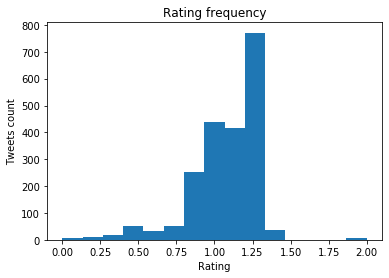

In [79]:
plt.hist(data = twitter_archive_clean, x = 'rating', bins=15)
plt.title("Rating frequency")
plt.xlabel("Rating")
plt.ylabel("Tweets count");

*Rating* presents a __left skewed distribution__. With very few __outliers__ with *rating* 2.0.

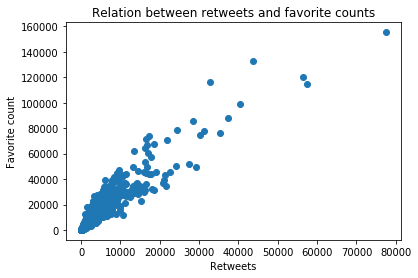

In [77]:
plt.scatter(data = twitter_archive_clean, x = 'retweet_count', y = 'favorite_count')
plt.title("Relation between retweets and favorite counts")
plt.xlabel("Retweets")
plt.ylabel("Favorite count");

In [78]:
np.corrcoef(twitter_archive_clean['retweet_count'], twitter_archive_clean['favorite_count'])[0][1]

0.9265953908768563

By the scatterplot and the correlation coefficient above, it is clear that there is a relation betweent *retweets* and *favorite count*.

In [136]:
breed1 = image_predictions_clean[image_predictions_clean['dog_1'] == True].prediction_1.value_counts()
breed1_10 = breed1.head(10)

In [137]:
breed1_10

golden_retriever      150
labrador_retriever    100
pembroke               89
chihuahua              83
pug                    57
chow                   44
samoyed                43
toy_poodle             39
pomeranian             38
malamute               30
Name: prediction_1, dtype: int64

The 10 most common breeds found by the neural network are:
* golden retriever
* labrador retriever
* pembroke
* chihuahua
* pug
* chow
* samoyed
* toy poodle
* pomeranian
* malamute